# Visualizations of one "adapted News Benchmark" simulation

## Import, load, and check if everything is correct

In [1]:
import random
import logging
import config
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

In [2]:
file_to_inspect = "simulation_outcome.train0111_7000k15_0.npy"
data = np.load(open(file_to_inspect, 'rb'))[()]

In [3]:
print("Keys: ",', '.join([key for key in data.keys()]), "\n")
for key in data.keys():
    if type(data[key]) is np.ndarray: 
        print("Shape %-11s %s" % (key, str(data[key].shape)))

Keys:  centroids_z, centroids_x, z, x, t, y, mu, s, y_pcf, mu_pcf, s_pcf, treatment_types 

Shape z           (7000, 50)
Shape x           (7000, 2869)
Shape t           (7000,)
Shape y           (7000, 4)
Shape mu          (7000, 4)
Shape s           (7000, 4)
Shape y_pcf       (7000, 3, 10)
Shape mu_pcf      (7000, 3, 10)
Shape s_pcf       (7000, 3, 10)


In [4]:
'''
Load data into variables for nicer access.
'''
z = data['z']
c_z = np.array(data['centroids_z'])
s = data['s']
mu = data['mu'][:,:]
y = data['y'][:,:]
y_pcf = data['y_pcf'][:,:]
x = data['x'][:,:]
t = data['t'][:]
n_treatments = c_z.shape[0]
n_samples = z.shape[0]

for i in range(3):
    print("Nr of units with treatment t=%d: %d" % (i, sum(t==i)))
    

Nr of units with treatment t=0: 2403
Nr of units with treatment t=1: 1227
Nr of units with treatment t=2: 1405


## Prepare data and visualize

In [5]:
'''
Dot product to centroid in topic space. 
Used for treatment assignment and outcome calculation.
'''
dist = np.zeros([n_treatments, n_samples])
for i in range(n_treatments):
    dist[i] = [np.dot(c_z[i],j) for j in z]

### Relationship: dot product, treatment strength, outcome

Treatment 1
Min treatment strength: 0.001
Max treatment strength: 1.000


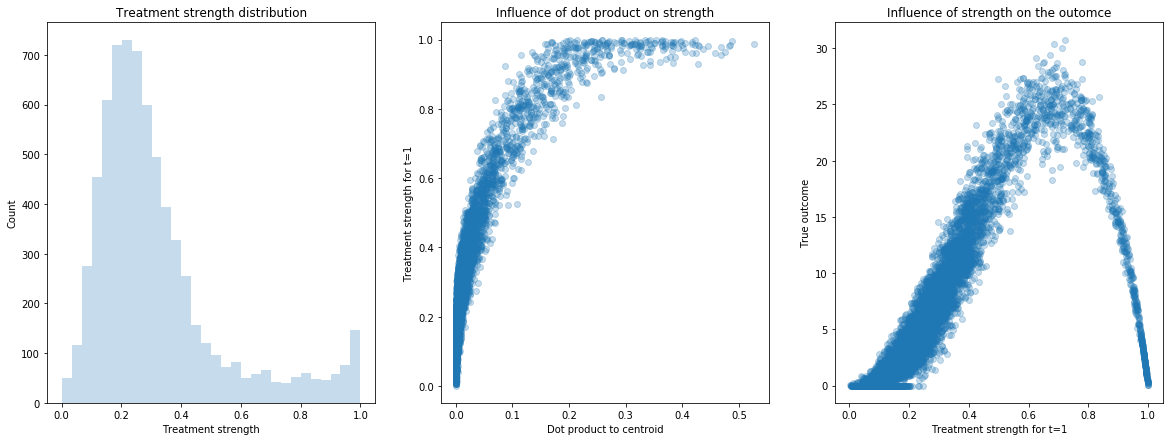

Treatment 2
Min treatment strength: 0.004
Max treatment strength: 1.000


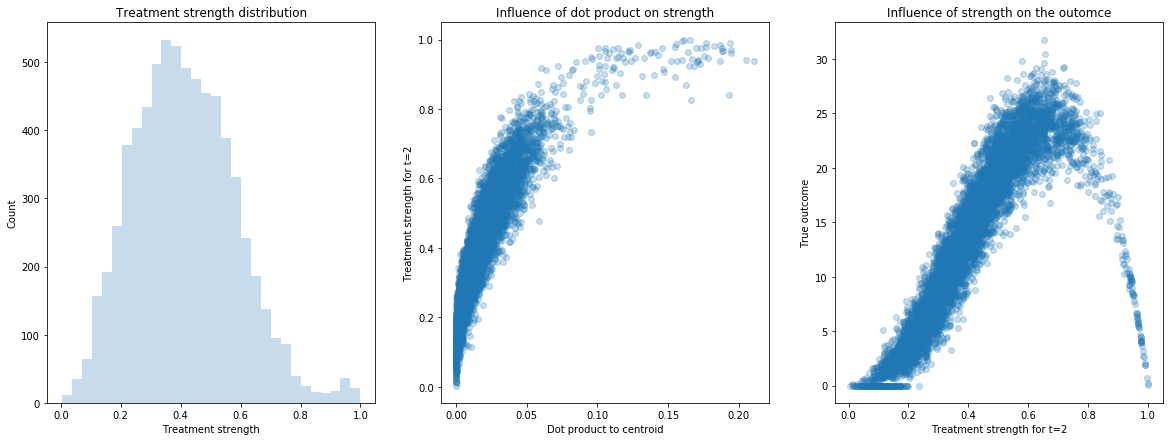

Treatment 3
Min treatment strength: 0.002
Max treatment strength: 0.992


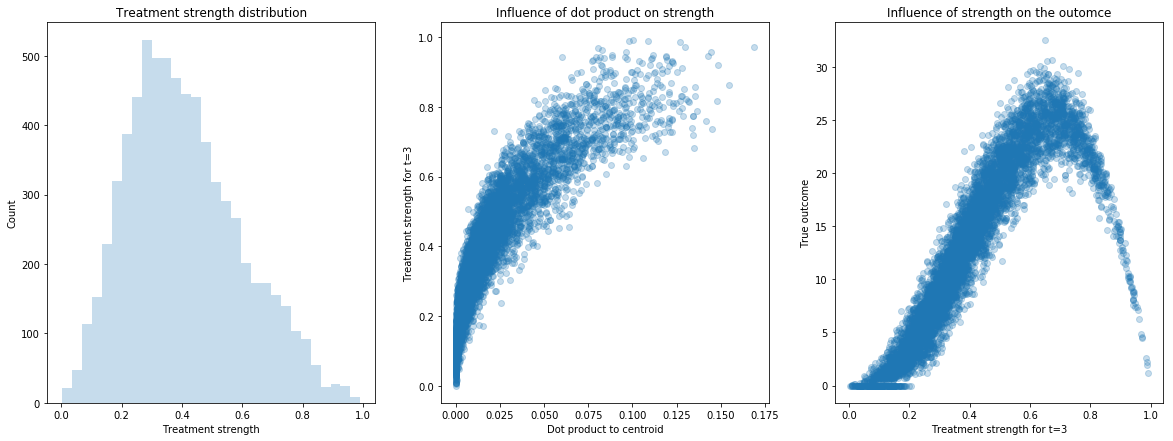

In [6]:
plt.rcParams['figure.figsize'] = (20.0, 7.0)

for i in range(n_treatments):
    if data["treatment_types"][i] > 0:
        print("Treatment %d" % i)
        print("Min treatment strength: %.3f" % min(s[:,i]))
        print("Max treatment strength: %.3f" % max(s[:,i]))

        plt.subplot(131)
        plt.hist(s[:,i], bins=30, alpha=0.25, label='s')
        plt.xlabel('Treatment strength')
        plt.ylabel('Count')
        plt.title("Treatment strength distribution")

        plt.subplot(132)
        plt.plot(dist[i], s[:,i], 'o', alpha=0.25)
        plt.xlabel('Dot product to centroid')
        plt.ylabel('Treatment strength for t=%d' % i)
        plt.title("Influence of dot product on strength")
        
        plt.subplot(133)
        plt.plot(s[:,i], mu[:,i],'o', alpha=0.25)
        plt.xlabel('Treatment strength for t=%d' % i)
        plt.ylabel('True outcome')
        plt.title("Influence of strength on the outomce")
        
        plt.show()

### Relationship: dot product, outcome; factual vs counterfactual distribution

Treatment 0


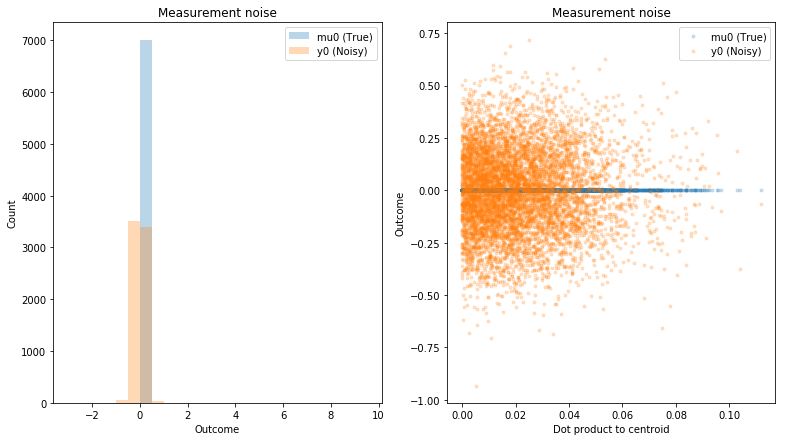

Treatment 1


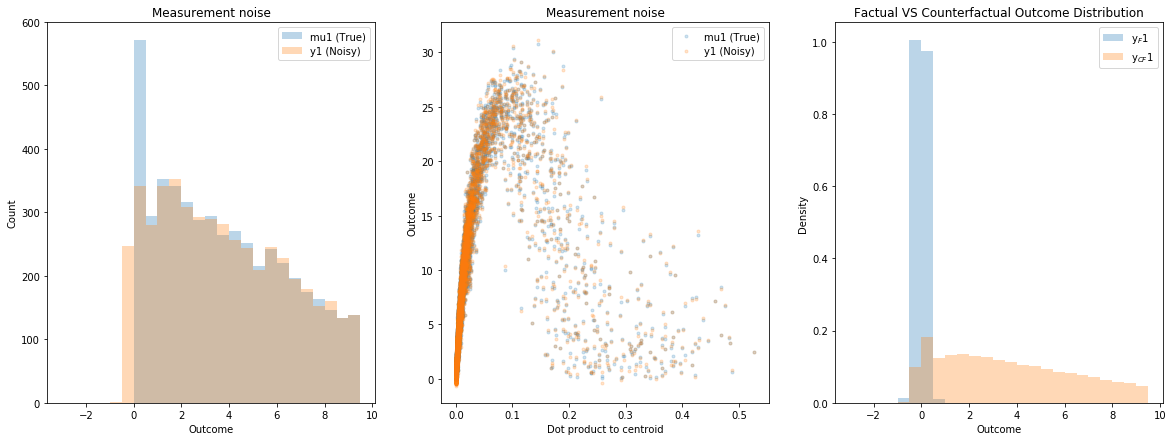

Treatment 2


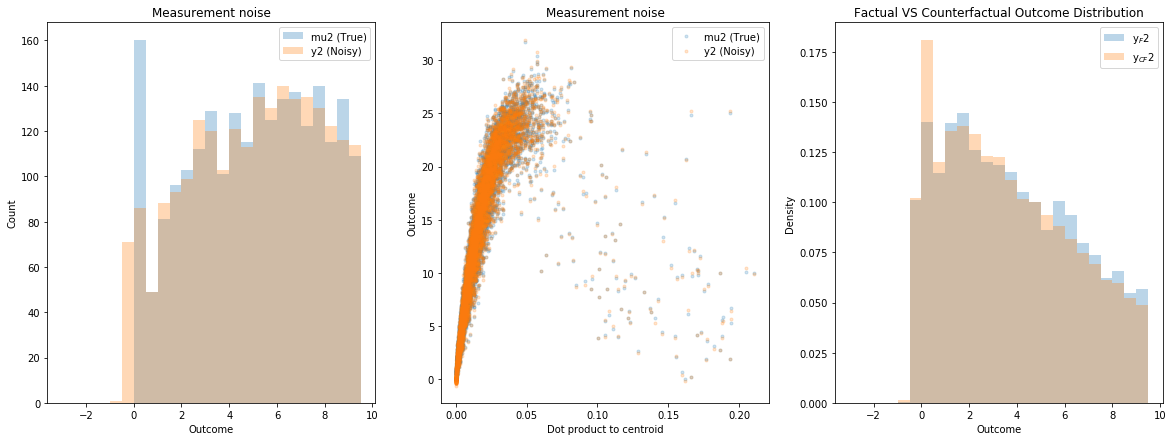

Treatment 3


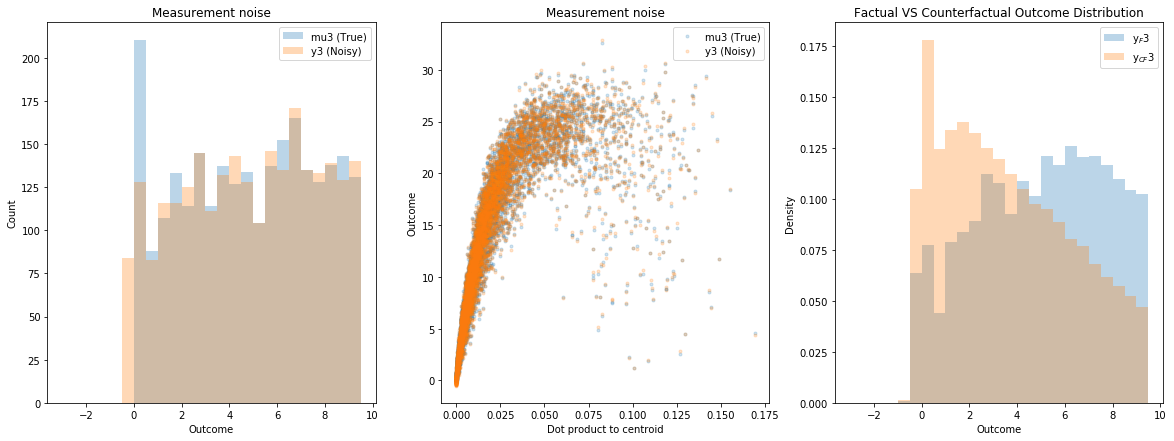

In [7]:
p_treatment_count = 0
for i in range(n_treatments):
    print("Treatment %d" % i)
    plt.subplot(131)
    plt.hist(mu[:,i], bins=np.arange(-3,10,0.5), alpha=0.3, label='mu'+str(i)+" (True)")
    plt.hist(y[:,i], bins=np.arange(-3,10,0.5), alpha=0.3, label='y'+str(i)+" (Noisy)")
    plt.xlabel('Outcome')
    plt.ylabel('Count')
    plt.title("Measurement noise")
    plt.legend()

    plt.subplot(132)
    plt.plot(dist[i], mu[:,i],'o', alpha=0.2, label='mu'+str(i)+" (True)", marker='.')
    plt.plot(dist[i], y[:,i],'o', alpha=0.2, label='y'+str(i)+" (Noisy)", marker='.')
    plt.xlabel('Dot product to centroid')
    plt.ylabel('Outcome')
    plt.title("Measurement noise")
    plt.legend()

    # Compare distribution of facutal and counterfactual outcomes
    # only for parametric treatments
    if data["treatment_types"][i] > 0:
        plt.subplot(133)
        plt.hist(y[:,p_treatment_count], bins=np.arange(-3,10,0.5), alpha=0.3, label='y$_F$'+str(i), density=True)
        plt.hist(y_pcf[:,p_treatment_count,:].flatten(), bins=np.arange(-3,10,0.5), alpha=0.3, label='y$_{CF}$'+str(i), density=True)
        plt.xlabel('Outcome')
        plt.ylabel('Density')
        plt.title("Factual VS Counterfactual Outcome Distribution")
        plt.legend()
        p_treatment_count += 1

    plt.show()

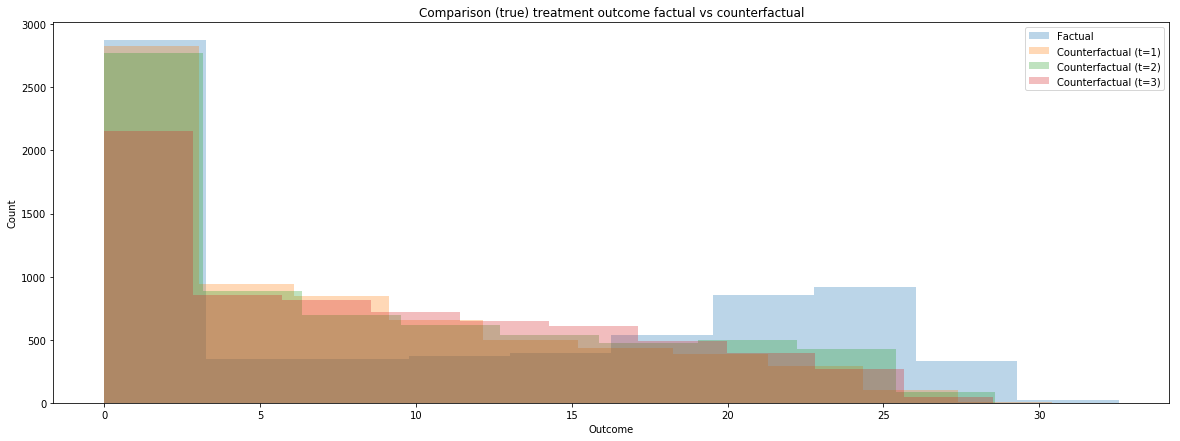

In [8]:
mu_f = mu[np.arange(n_samples), t.astype(int)]
plt.figure()
plt.title("Comparison (true) treatment outcome factual vs counterfactual")
plt.hist(mu_f, alpha=0.3, label="Factual")
for i in range(1, n_treatments):
    mu_cf = mu[np.arange(n_samples), np.mod(t+i,n_treatments).astype(int)]
    plt.hist(mu_cf, alpha=0.3, label="Counterfactual (t=%d)" %i)
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.legend()
plt.show()

### Visulization of the word space and topic space

Nr of centroids = 4
Dimensionality of centroids = 2869


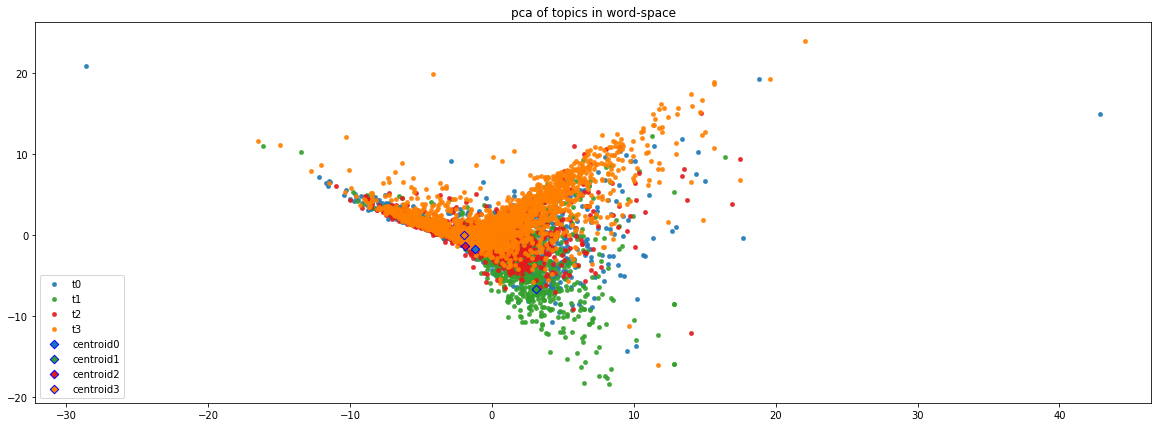

Nr of centroids = 4
Dimensionality of centroids = 50


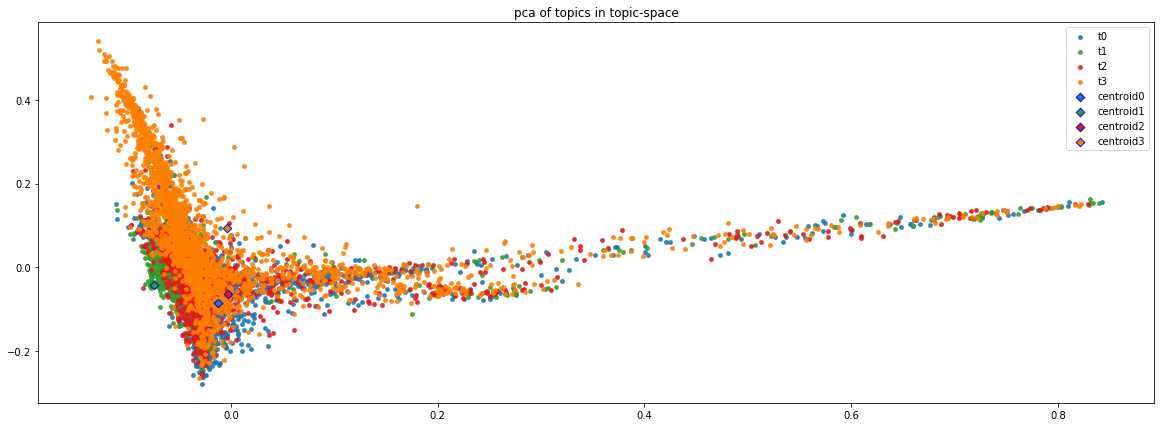

Nr of centroids = 4
Dimensionality of centroids = 50


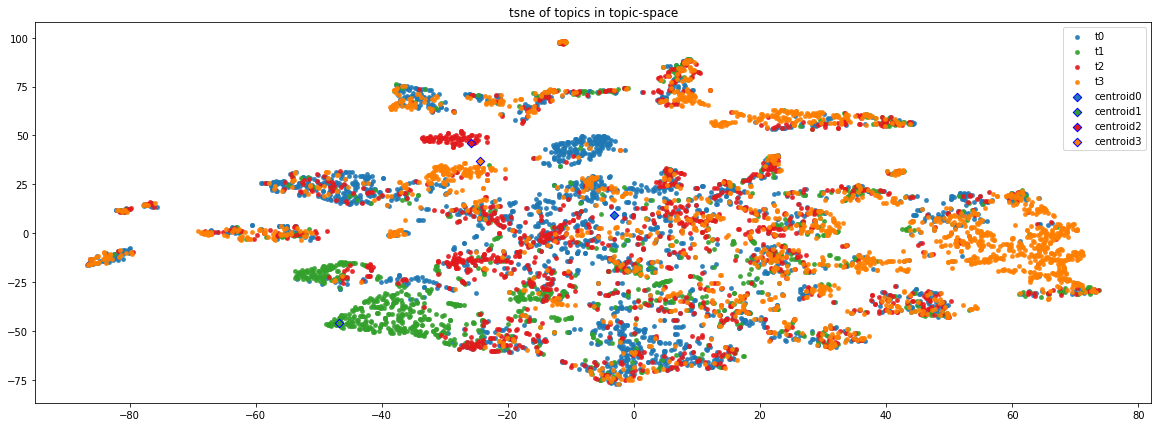

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_DR(data, centroids, space_name, algo="pca"):
    x = data
    c_x = centroids 
    n_treatments = len(centroids)
    
    print("Nr of centroids = %d" % len(c_x))
    print("Dimensionality of centroids = %d" % len(c_x[0]))
    if algo is "pca":
        pca = PCA(n_components=2)
        pca = pca.fit(x)
        x_r = pca.transform(x)
        centroids_r = pca.transform(c_x)

    elif algo is "tsne":
        tsne = TSNE(n_components=2)
        tsne = tsne.fit_transform( np.concatenate((data, centroids)) )
        x_r = tsne[:-n_treatments,:]
        centroids_r = tsne[-n_treatments:,:]
    
    plt.figure()

    cmap_data = plt.cm.get_cmap('Paired')
    colors = [cmap_data(i*2+1) for i in range(n_treatments)]

    # Plot points
    for color, i, target_name in zip(colors, np.arange(n_treatments), ["t"+str(i) for i in range(n_treatments)]):
        plt.scatter(x_r[t == i,0], x_r[t == i,1], color=color, alpha=0.8, lw=2, label=target_name, marker='.')
    
    # Plot centroids
    for color, i, target_name in zip(colors, np.arange(n_treatments), ["centroid"+str(i) for i in range(n_treatments)]):
        centroid_r = centroids_r[i]
        plt.scatter(centroid_r[0], centroid_r[1], color=color, lw=1, label=target_name, marker='D', edgecolors='b')
    
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(algo + ' of topics in ' + space_name)
    plt.show()

c_x = np.array(data['centroids_x'])

plot_DR(x, c_x, "word-space", algo="pca")
plot_DR(z, c_z, "topic-space", algo="pca")
plot_DR(z, c_z, "topic-space", algo="tsne")  # This takes a while